# 17. Frame Selected Discriminality and ICC

In [2]:
from src import *

In [3]:
import pingouin

## Description

We evaluate frame selected's discriminality and ICC values. 

GOAL: Compute frame selected's discriminality and ICC values. 

## Table of Contents
- [Frame selected and discrim / ICC](#comparison)

<a class="anchor" id="comparison"></a>
## Frame selected (by emotion) gradients

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

D = lambda x,y: ((x-y)**2).sum(axis=1)

Load frame selected and full movie gradients (individual level)

In [5]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/treshed_series.pkl')

if 'Rest' in f_series: del fselect_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [6]:
def persubject_grad(series, S):
    ## Warn: global variables here don't use it elsewhere
    fselect = {_id:[] for _id in series['Sintel'].keys()}
    # array swap
    for mname in S:
        tmp_dict = series[mname]

        for _id in tmp_dict:
            tmp_series = tmp_dict[_id]
            fselect[_id].append(tmp_series)

    # all movies gradients compute
    gradients = {}
    for _id in fselect:
        tmp_series = np.concatenate(fselect[_id])
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_

        fscore = D(grad.mean(axis=0), grad)
        gradients[_id] = fscore

    return gradients

def multiple_icc(test,retest):
    # test and retest multiple times along input arrays
    # test and retest are of format dict('target1': 1darray, 'target2': 1darray ...)
    icc_array = []
    n_iter = test[next(iter(test))].shape[0]
    for idx in range(n_iter):
        df = {'type': [], 'id': [], 'fscore': []}

        for _id in test.keys():
            df['id'] += [int(_id[1:])]
            df['fscore'] += [test[_id][idx]]
            df['type'] += ['test']

            df['id'] += [int(_id[1:])]
            df['fscore'] += [retest[_id][idx]]
            df['type'] += ['retest']

        df = pd.DataFrame.from_dict(df)

        icc = pingouin.intraclass_corr(data=df, targets='id', raters='type', ratings='fscore')
        icc_array.append(np.round(list(icc['ICC']),3)[2])
    
    return icc_array

#### Test-Retest classes

In [ ]:
set1 = list(total_series.keys())[:len(total_series)//2]
set2 = list(total_series.keys())[len(total_series)//2:]

In [105]:
print(set1),print(set2)

['ToClaireFromSonny', 'TheSecretNumber', 'Chatter', 'LessonLearned', 'Payload', 'AfterTheRain', 'Superhero']
['Sintel', 'TearsOfSteel', 'BetweenViewing', 'BigBuckBunny', 'YouAgain', 'Spaceman', 'FirstBite']


(None, None)

### Compute ICC across ID using as class the test or retest 

In [8]:
s20 = [(s,s+20) for s in range(0,101,10) if (s+20 <= 100)]

icc_bounds20 = {}
for bound in tqdm(s20):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])

        icc_array = multiple_icc(fselect1_gradients, fselect2_gradients)
        step_array.append(icc_array)
    
    icc_bounds20[bound] = step_array

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
s30 = [(s,s+30) for s in range(0,101,10) if (s+30 <= 100)]

icc_bounds30 = {}
for bound in tqdm(s30):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])

        icc_array = multiple_icc(fselect1_gradients, fselect2_gradients)
        step_array.append(icc_array)
    
    icc_bounds30[bound] = step_array

  0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
s40 = [(s,s+40) for s in range(0,101,10) if (s+40 <= 100)]

icc_bounds40 = {}
for bound in tqdm(s40):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])

        icc_array = multiple_icc(fselect1_gradients, fselect2_gradients)
        step_array.append(icc_array)
    
    icc_bounds40[bound] = step_array

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
step_iccfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    
    icc_fullarray = multiple_icc(ftotal1_gradients, ftotal2_gradients)
    step_iccfull.append(icc_fullarray)

#### Visualize results

/tmp/ipykernel_113997/1149502375.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,8))


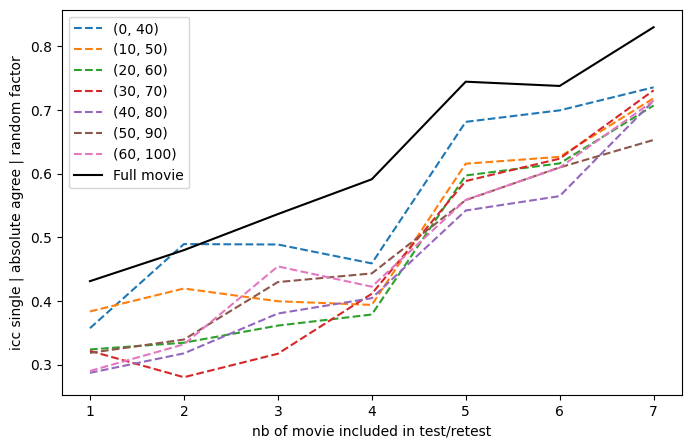

In [101]:
fig,ax = plt.subplots(figsize=(8,5))
for k in range(len(s40)):
    ax.plot(np.asarray([icc_bounds40[s] for s in s40]).mean(axis=-1)[k],
            linestyle='--', label='{}'.format(s40[k]))

ax.plot(np.asarray(step_iccfull).mean(axis=1), label='Full movie', color='k')
    

ax.legend()
ax.set_xlabel('nb of movie included in test/retest')
ax.set_ylabel('icc single | absolute agree | random factor')
ax.set_xticklabels(np.arange(0,8))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

/tmp/ipykernel_113997/4024488556.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,8))


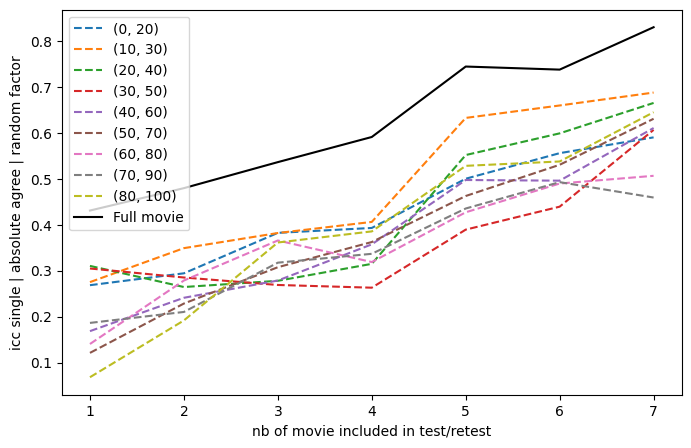

In [102]:
fig,ax = plt.subplots(figsize=(8,5))
for k in range(len(s20)):
    ax.plot(np.asarray([icc_bounds20[s] for s in s20]).mean(axis=-1)[k],
            linestyle='--', label='{}'.format(s20[k]))

ax.plot(np.asarray(step_iccfull).mean(axis=1), label='Full movie', color='k')
    

ax.legend()
ax.set_xlabel('nb of movie included in test/retest')
ax.set_ylabel('icc single | absolute agree | random factor')
ax.set_xticklabels(np.arange(0,8))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

/tmp/ipykernel_113997/4291871603.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,8))


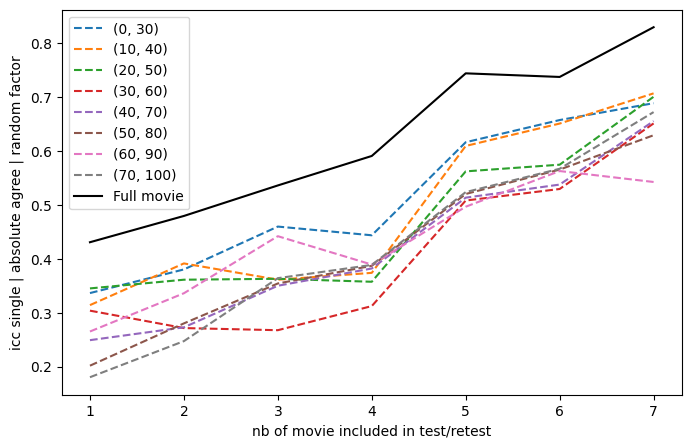

In [103]:
fig,ax = plt.subplots(figsize=(8,5))
for k in range(len(s30)):
    ax.plot(np.asarray([icc_bounds30[s] for s in s30]).mean(axis=-1)[k],
            linestyle='--', label='{}'.format(s30[k]))

ax.plot(np.asarray(step_iccfull).mean(axis=1), label='Full movie', color='k')
    

ax.legend()
ax.set_xlabel('nb of movie included in test/retest')
ax.set_ylabel('icc single | absolute agree | random factor')
ax.set_xticklabels(np.arange(0,8))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

### Discriminality

In [20]:
distance = lambda x,y: 1 - pearson_correlation(x,y)

def compute_discriminality(samples):
    nb_smp = samples.shape[0]
    dist_mat = np.zeros((nb_smp,nb_smp))

    for k in range(nb_smp):
        for j in range(nb_smp):
            dist_mat[k,j] = distance(samples[k],samples[j])

    discrim = []
    for k in range(nb_smp//2):
        sample_size = nb_smp-1 # remove 1 for identity
        discrim.append(np.sum(dist_mat[k][30+k] <= dist_mat[k])/sample_size)
    
    return np.mean(discrim)

In [73]:
s20 = [(s,s+20) for s in range(0,101,10) if (s+20 <= 100)]

dis_bounds20 = {}
for bound in tqdm(s20):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])
        samples = np.array(list(fselect1_gradients.values()) + list(fselect2_gradients.values()))
        
        dis_array = compute_discriminality(samples)
        step_array.append(dis_array)
    
    dis_bounds20[bound] = step_array

  0%|          | 0/9 [00:00<?, ?it/s]

In [74]:
s30 = [(s,s+30) for s in range(0,101,10) if (s+30 <= 100)]

dis_bounds30 = {}
for bound in tqdm(s30):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])
        samples = np.array(list(fselect1_gradients.values()) + list(fselect2_gradients.values()))
        
        dis_array = compute_discriminality(samples)
        step_array.append(dis_array)
    
    dis_bounds30[bound] = step_array

  0%|          | 0/8 [00:00<?, ?it/s]

In [72]:
s40 = [(s,s+40) for s in range(0,101,10) if (s+40 <= 100)]

dis_bounds40 = {}
for bound in tqdm(s40):
    fselected_series = f_series[1][bound]

    step_array = []
    for k in range(1,len(set1)+1):
        # Grouping test-retest
        fselect1_gradients = persubject_grad(fselected_series,set1[:k])
        fselect2_gradients = persubject_grad(fselected_series,set2[:k])
        samples = np.array(list(fselect1_gradients.values()) + list(fselect2_gradients.values()))
        
        dis_array = compute_discriminality(samples)
        step_array.append(dis_array)
    
    dis_bounds40[bound] = step_array

  0%|          | 0/7 [00:00<?, ?it/s]

In [64]:
step_disfull = []
for k in range(1,len(set1)+1):
    # Grouping test-retest
    ftotal1_gradients = persubject_grad(total_series,set1[:k])
    ftotal2_gradients = persubject_grad(total_series,set2[:k])
    samples = np.array(list(ftotal1_gradients.values()) + list(ftotal2_gradients.values()))
    
    dis_fullarray = compute_discriminality(samples)
    step_disfull.append(dis_fullarray)

#### Visualize results

/tmp/ipykernel_113997/613102457.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(0,8))


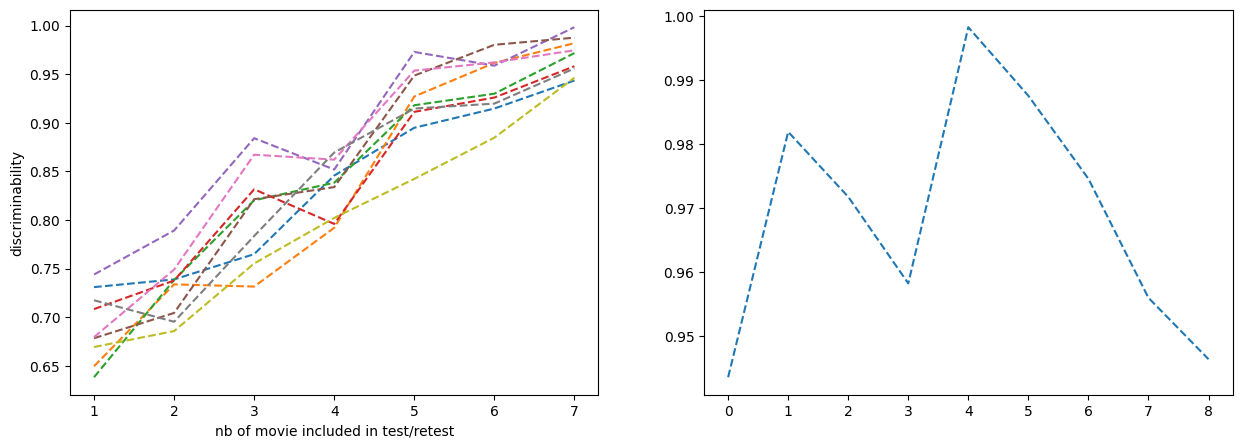

In [114]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for k in range(len(s20)):
    ax[0].plot(np.asarray([dis_bounds20[s] for s in s20])[k],linestyle='--')

ax[1].plot(np.asarray([dis_bounds20[s][-1] for s in s20]),linestyle='--')

/tmp/ipykernel_113997/3518544301.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(0,8))
/tmp/ipykernel_113997/3518544301.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([()]+s30)


Text(0, 0.5, 'discriminability with 7 movies')

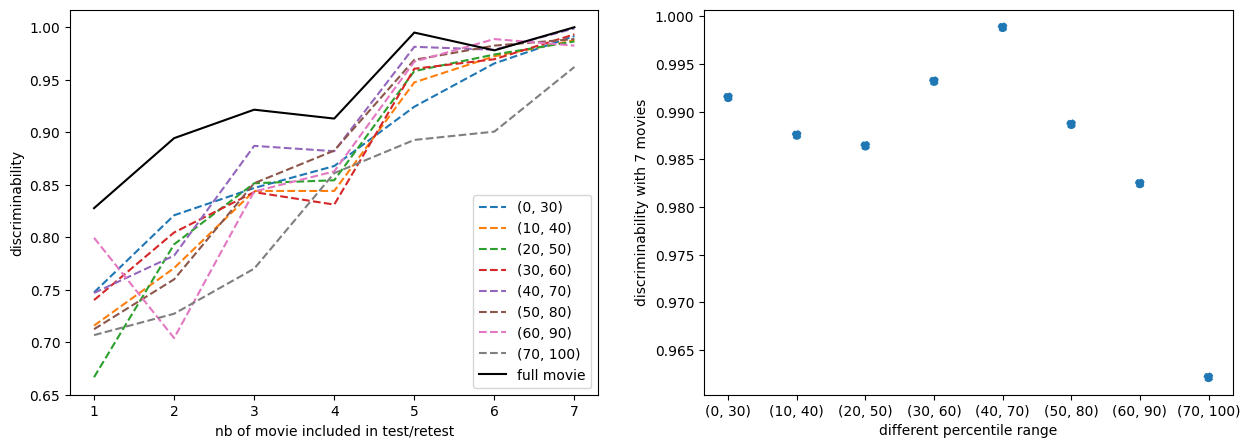

In [123]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for k in range(len(s30)):
    ax[0].plot(np.asarray([dis_bounds30[s] for s in s30])[k],linestyle='--',label=s30[k])
    
ax[0].plot(step_disfull, label='full movie', color='k')
ax[0].set_xlabel('nb of movie included in test/retest')
ax[0].set_ylabel('discriminability')
ax[0].set_xticklabels(np.arange(0,8))
ax[0].legend()


ax[1].scatter(np.arange(len(s30)),np.asarray([dis_bounds30[s][-1] for s in s30]),linestyle='--')
ax[1].set_xticklabels([()]+s30)
ax[1].set_xlabel('different percentile range')
ax[1].set_ylabel('discriminability with 7 movies')

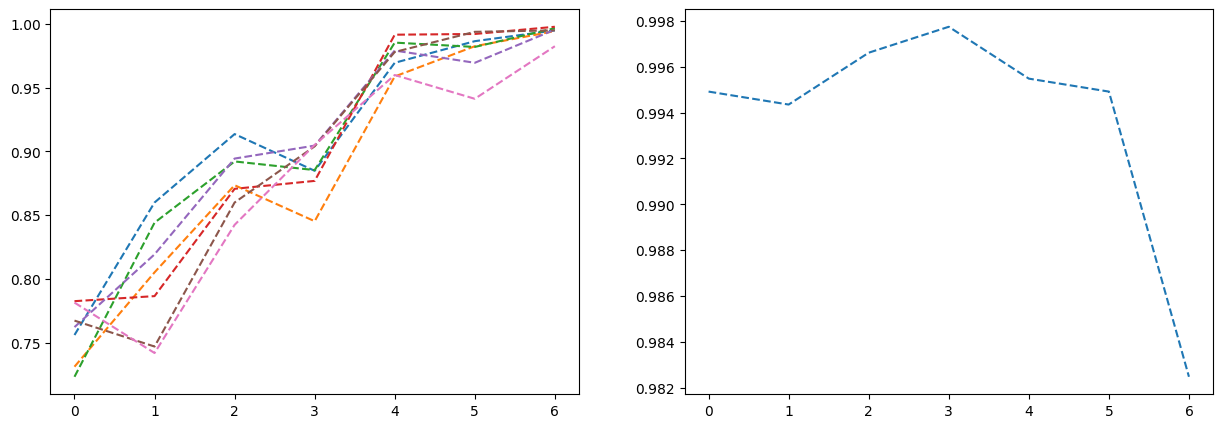

In [80]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
for k in range(len(s40)):
    ax[0].plot(np.asarray([dis_bounds40[s] for s in s40])[k],linestyle='--')
    
ax[1].plot(np.asarray([dis_bounds40[s][-1] for s in s40]),linestyle='--')

Visual explanation of what discriminality is

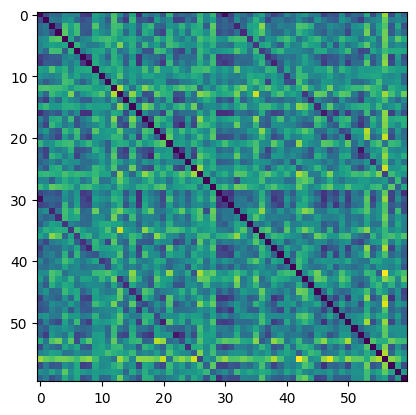

In [50]:
plt.imshow(dist_mat)